In [ ]:
!pip install deeplay -q
!pip install deeptrack -q
!pip install andi_datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.2/175.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.4/899.4 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.0/292.0 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import logging

from sklearn.metrics import f1_score

import imageio
import torch

import deeplay as dl
import deeptrack as dt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from andi_datasets.utils_videos import play_video
import utils_tracking as utils

logging.disable(logging.WARNING)

### Load experimental data

0.0

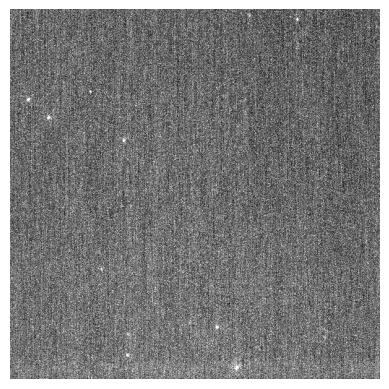

In [42]:
# Load video.
reader = imageio.get_reader("10mbar_1_high_contrast.tif",format="tiff")

# reader.get_data(0) returns a series of images (frame_id, width, height),
#   we then select the first frame in this image series with [0].
experimental_video = np.array(reader.get_data(0))

# Select a frame and display.
video_frame = utils.normalize_min_max(experimental_video[0])
plt.imshow(video_frame, cmap="gray")
plt.axis("off");

### Simulating data.
Simulate Brownian motion trajectories using Gaussian perturbations at each time step.

In [75]:

def simulate_Brownian_trajs(num_particles, num_timesteps, R, l):

    # Get initial positions of particles.
    start_positions = utils.generate_centroids(
        num_particles=num_particles,
        box_size=2*l,
        R=R,
    )
    pos = np.empty([num_particles,2])
    trajs_gt = np.empty([num_timesteps, num_particles, 2 + 1])

    # Add particle positions to array.
    pos[:, 0] = start_positions[:, 0] % (2 * l) - l
    pos[:, 1] = start_positions[:, 1] % (2 * l) - l

    # Add particle positions to array.
    for j in range(num_particles):
        trajs_gt[0, j, 0] = pos[j, 0] + l
        trajs_gt[0, j, 1] = pos[j, 1] + l
        trajs_gt[0, j, 2] = 0

    # Time simulation.
    for t in range(num_timesteps - 1):

        # Perform random step.
        pos[:, 0] = (pos[:, 0] + .6 + np.random.normal(0, 0.4, num_particles) + l) % (2 * l) - l
        pos[:, 1] = (pos[:, 1] + np.random.normal(0, 0.05, num_particles) + l) % (2 * l) - l

        # Add particle positions to array.
        for particle_idx in range(num_particles):
            trajs_gt[t + 1, particle_idx, 0] = pos[particle_idx, 0] + l
            trajs_gt[t + 1, particle_idx, 1] = pos[particle_idx, 1] + l
            trajs_gt[t + 1, particle_idx, 2] = t + 1
    return trajs_gt



In [76]:
N = 40     # Number of timesteps.
l = 140    # Half box size.
n = 15

trajs_gt = simulate_Brownian_trajs(n, N, 3, l)

# Break trajectories passing in and out of the field of view.
trajs_gt_list = utils.traj_break(trajs_gt, l, trajs_gt.shape[1])

### Generate movie, and compare with experimental data.

In [ ]:
# Eliminate axis with frames from trajs_gt with np.delete.
sim_movie = utils.transform_to_video(np.delete(trajs_gt, 2, 2),
    image_size=int(2*l),
    save_video=True,
    maps=False,
    path="./myvideo.tiff",
)

play_video(sim_movie)
#play_video(experimental_video)


### Localizations with LodeSTAR.
In order to generate a trajectory from the experimental data we will utilize LodeSTAR localizations, as shown in the
**Detections** notebooks.\
We start by obtaining a crop of our data.


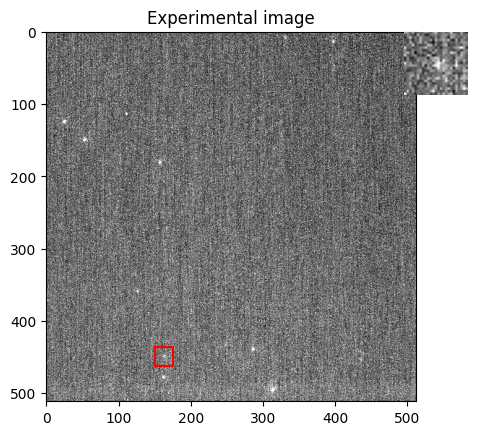

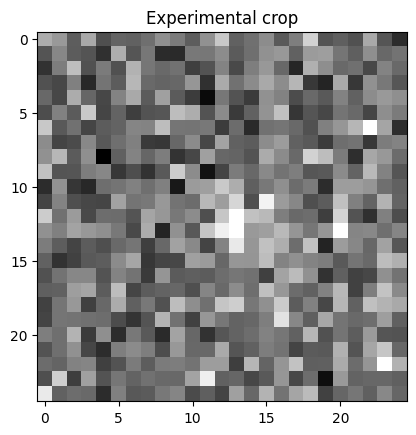

(25, 25)

In [7]:
fig   = plt.figure()
width = 25
x = 437
y = 150
# Draw a red rectangle around the crop
crop = video_frame[x:x+width, y:y+width]
fig.add_subplot(111)
plt.imshow(video_frame, cmap="gray")
plt.plot([y, y+width, y+width, y, y],
         [x, x, x+width, x+width, x], "r-")
plt.title("Experimental image")

# Add the crop on the top right corner
fig.add_subplot(555)
plt.imshow(crop, cmap="gray")
plt.axis("off")
plt.show()
# Open a figure instance
fig = plt.figure()
# Display the simulated crop
plt.imshow(crop, cmap="gray")
plt.title("Experimental crop")
plt.show()


# Convert to numpy array.
experimental_crop_tensor = crop
crop.shape


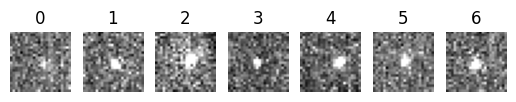

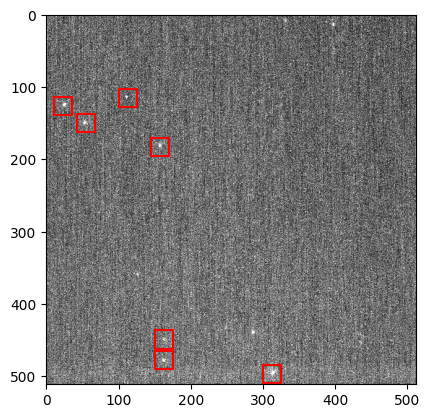

In [8]:
import random
training_images = []
ys = np.array([ 150, 150, 300, 100, 10, 145, 42] ) #Horizontal
xs = np.array([ 437, 466, 485, 102, 113, 170, 137])#Vertical

for i in range(len(ys)):
    # Go through the locations of the crops in the image.
    y_index   = ys[i]
    x_index   = xs[i]
    crop_size = 24

    # Crop a window in the image.
    x0, y0 = y_index , x_index
    training_image = np.array(video_frame[y0: y0 + crop_size, x0:x0 + crop_size,])

    # Expand dims with np.newaxis and append to list.
    training_images.append(training_image[:, :, np.newaxis])

    # Display in subplots.
    plt.subplot(1,len(ys),i + 1)
    plt.axis("off")
    plt.title(f"{i}")
    plt.imshow(training_image, cmap="gray")

plt.figure()
plt.imshow(video_frame, cmap="gray")
plt.plot([ys, ys + width, ys + width, ys, ys],
         [xs, xs, xs + width, xs + width, xs], "r-")

random_crop = dt.Value(lambda: random.choice(training_images))

In [148]:
# Initiate LodeSTAR.
lodestar_exp = dl.LodeSTAR(n_transforms=8,
                   optimizer=dl.Adam(lr=1e-3)).build()

# Define training pipeline and dataloader.
training_pipeline = (
    dt.Value(random_crop)
    >> dt.NormalizeMinMax(0.1, 1.0)
   # >> dt.Pool(np.mean, 2)
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)
train_dataset = dt.pytorch.Dataset(training_pipeline,
                                   length=512,
                                   replace=False
                                  )
dataloader = dl.DataLoader(train_dataset,
                           batch_size=16,
                           shuffle=True,
                          )


### Training

In [149]:
load_model = False
#  Check if weights exist.
if not os.path.isfile("lodestar_weights_exp") or not load_model:

    #  Start training.
    trainer_lodestar = dl.Trainer(max_epochs=64)
    trainer_lodestar.fit(lodestar_exp, dataloader)
    torch.save(lodestar_exp.state_dict(),"lodestar_weights_exp")
else:
    #  Load pre-existing weights.
    lodestar_exp.load_state_dict(torch.load("lodestar_weights_exp",
                                             weights_only=True)
    )
lodestar_exp.eval();

C:\Users\Alex Lech\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  251 K │ train │
│ 1 │ between_loss  │ L1Loss                     │      0 │ train │
│ 2 │ within_loss   │ L1Loss                     │      0 │ train │
│ 3 │ train_metrics │ MetricCollection           │      0 │ train │
│ 4 │ val_metrics   │ MetricCollection           │      0 │ train │
│ 5 │ test_metrics  │ MetricCollection           │      0 │ train │
│ 6 │ optimizer     │ Adam                       │      0 │ train │
└───┴───────────────┴────────────────────────────┴────────┴───────┘

Trainable params: 251 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 251 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 39                                                                                          
Modules in eval mode: 0

Output()

C:\Users\Alex Lech\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\Alex Lech\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


### Perform a test detection to adjust parameters if needed.

Found 11 test detections.


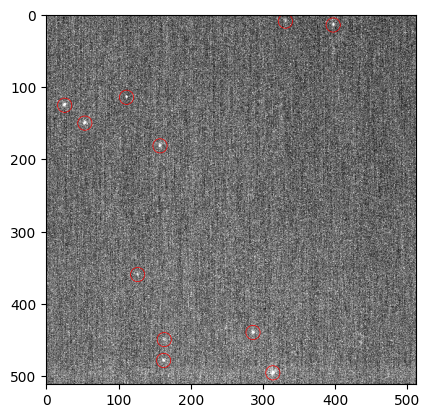

In [150]:
image_of_particles = torch.from_numpy(video_frame[np.newaxis,
                                                  np.newaxis, :,:]).float()
#  Parameters for inference.
alpha  = 0.25
beta   = 1-alpha
cutoff = 0.35

# Infer pos from experimental image.
detections_M4_experimental = lodestar_exp.detect(image_of_particles,
                         alpha  = alpha,
                         beta   = beta,
                         mode   = "constant",
                         cutoff = cutoff
)[0]

# Print detection number for reference.
test_detections = len(detections_M4_experimental[:, 1])
print(f"Found {test_detections} test detections.")


plt.figure()
plt.imshow(video_frame[:, :].squeeze(),cmap="gray")
plt.scatter(detections_M4_experimental[:, 1],
            detections_M4_experimental[:, 0],
            edgecolors="r",marker="o",facecolors="none",linewidths=0.5, s=105)

Using lodeSTAR: get localizations in all the frames of the video,\
and create a pandas dataframe.

In [151]:
import time
df_exp = []

print(f"Getting LodeSTAR detections for {len(experimental_video)} frames...")
start_time = time.time()
for frame_index, frame in enumerate(experimental_video):

    # Reshape image, needs to be in (N, C, X, Y) format.
    frame = utils.normalize_min_max(frame[:, :])
    image_for_lodestar =  torch.from_numpy(frame).unsqueeze(0).unsqueeze(0).float()


    # Get detections from LodeSTAR.
    localizations = lodestar_exp.detect(image_for_lodestar,
        alpha = alpha,
        beta = beta,
        cutoff = cutoff,
        mode = "constant",
    )[0]

    # Process and add to dataframe.
    _df = pd.DataFrame(localizations, columns=["x", "y"])
    _df["frame"] = frame_index
    df_exp.append(_df)

    if frame_index == 0:
      time_per_frame = time.time() - start_time
      estimated_total_time = time_per_frame * len(experimental_video)
      print(f"Estimated time to completion: {round(estimated_total_time/60)} minutes.")

    # Print every 10 frames no. of detections.
    if frame_index % 10 == 0:
        print(f"Detections in frame {frame_index}: {len(localizations)}")


DF_exp = pd.concat(df_exp, ignore_index=True)
DF_exp.__len__()

DF_test = DF_exp.rename(columns = {"y":"centroid-1", "x":"centroid-0"})
DF_test["label"], DF_test["set"],DF_test["solution"] = 0, 0, 0


# Normalize centroids between 0 and 1.
_length = frame.shape[0]
_width  = frame.shape[1]
DF_test.loc[:, DF_test.columns.str.contains("centroid")] = (
    DF_test.loc[:, DF_test.columns.str.contains("centroid")]
    / np.array([_length, _width])
)

print("Finished generating dataframe from detections.")

Getting LodeSTAR detections for 338 frames...
Estimated time to completion: 1 minutes.
Detections in frame 0: 11
Detections in frame 10: 10
Detections in frame 20: 11
Detections in frame 30: 12
Detections in frame 40: 10
Detections in frame 50: 8
Detections in frame 60: 8
Detections in frame 70: 8
Detections in frame 80: 8
Detections in frame 90: 8
Detections in frame 100: 7
Detections in frame 110: 9
Detections in frame 120: 8
Detections in frame 130: 7
Detections in frame 140: 9
Detections in frame 150: 7
Detections in frame 160: 8
Detections in frame 170: 5
Detections in frame 180: 8
Detections in frame 190: 8
Detections in frame 200: 7
Detections in frame 210: 7
Detections in frame 220: 7
Detections in frame 230: 8
Detections in frame 240: 8
Detections in frame 250: 6
Detections in frame 260: 8
Detections in frame 270: 9
Detections in frame 280: 6
Detections in frame 290: 4
Detections in frame 300: 5
Detections in frame 310: 6
Detections in frame 320: 6
Detections in frame 330: 6
F

## Tracking with MAGIK

### Simulate a training dataset

In [152]:
df_training = []
df=[]
l = 100
number_of_videos = 60

_nParticles = 20
for _ivid in range(number_of_videos):
    _trajs_training = simulate_Brownian_trajs(_nParticles, 200, 2, l)
    _trajs_list_training = utils.traj_break(_trajs_training,l,_nParticles)

    for _i, _t in enumerate(_trajs_list_training):
        _df = pd.DataFrame(_t[:,1:], columns=["centroid-0", "centroid-1"])
        _df["frame"] = _t[:,0].astype(int)
        _df["label"] = _i
        _df["set"] = f"{_ivid}"
        df.append(_df)

print(f"Finished simulating {_ivid} movies.")

df_training = pd.concat(df, ignore_index=True)

# Normalize centroids between 0 and 1.
df_training.loc[:, df_training.columns.str.contains("centroid")] = (
    df_training.loc[:, df_training.columns.str.contains("centroid")]
    / np.array([2.0*l, 2.0*l])
)
df_training.head()

Finished simulating 59 movies.


,centroid-0,centroid-1,frame,label,set
0,0.935450,0.251193,0,0,0
1,0.939345,0.251067,1,0,0
2,0.943511,0.251105,2,0,0
3,0.946230,0.251123,3,0,0
4,0.947979,0.251242,4,0,0


### Define graph extraction class.
In order to use this class in a plug-and-play way, your data needs to be in the
dataframe format, i.e a pandas dataframe with\
centroids-0, centroid-1, frame, label, set.


In [153]:
graph_constructor = utils.GraphFromTrajectories(connectivity_radius = 0.1,
                                                max_frame_distance  = 3)

Generate graph from training data

In [154]:
train_graph = graph_constructor(df=df_training)
print(train_graph)

[Data(x=[3993, 2], edge_index=[2, 17711], edge_attr=[17711, 1], y=[17711, 1], distance=[17711, 1], frames=[3993]), Data(x=[3992, 2], edge_index=[2, 16634], edge_attr=[16634, 1], y=[16634, 1], distance=[16634, 1], frames=[3992]), Data(x=[3986, 2], edge_index=[2, 19669], edge_attr=[19669, 1], y=[19669, 1], distance=[19669, 1], frames=[3986]), Data(x=[3988, 2], edge_index=[2, 15657], edge_attr=[15657, 1], y=[15657, 1], distance=[15657, 1], frames=[3988]), Data(x=[3986, 2], edge_index=[2, 18145], edge_attr=[18145, 1], y=[18145, 1], distance=[18145, 1], frames=[3986]), Data(x=[3985, 2], edge_index=[2, 18089], edge_attr=[18089, 1], y=[18089, 1], distance=[18089, 1], frames=[3985]), Data(x=[3984, 2], edge_index=[2, 17177], edge_attr=[17177, 1], y=[17177, 1], distance=[17177, 1], frames=[3984]), Data(x=[3984, 2], edge_index=[2, 16990], edge_attr=[16990, 1], y=[16990, 1], distance=[16990, 1], frames=[3984]), Data(x=[3988, 2], edge_index=[2, 18407], edge_attr=[18407, 1], y=[18407, 1], distance=[

In [155]:
from torchvision.transforms import Compose
from torch_geometric.loader import DataLoader

# Initialize the graph dataset class.
train_set = utils.GraphDataset(train_graph,
        dataset_size=number_of_videos,
        Dt=10,
        
        transform=Compose(
                [
                        utils.RandomRotation(),
                        utils.RandomFlip(),
                        utils.NodeDropout()
                ] 
        )
)
# Initialize the training data loader.
train_loader = DataLoader(train_set,
        batch_size=4,
        shuffle=True,
        drop_last=True
)

### Initialize MAGIK.

In [156]:
model = dl.GraphToEdgeMAGIK([96,] * 4,1, out_activation=torch.nn.Sigmoid)
model.encoder[0].configure(hidden_features=[32, 64],
                           out_features=96,
                           out_activation=torch.nn.ReLU
)

model.encoder[1].configure(hidden_features=[32, 64],
                           out_features=96,
                           out_activation=torch.nn.ReLU
)
model.head.configure(hidden_features=[64, 32]);

In [157]:
classifier = dl.BinaryClassifier(model=model,
                                 optimizer=dl.Adam(lr=1e-3)
)
classifier = classifier.create()

### Load pretrained model or train a new one.



In [158]:
load_model = False

if load_model:
    print("Loading model...")
    model.load_state_dict(torch.load("./models/MAGIK.h5",weights_only=True))
else:
    # MAGIK benefits from a high epoch number.
    trainer = dl.Trainer(max_epochs=100)
    trainer.fit(classifier,train_loader)

    print("saving model...")
    os.makedirs("models/", exist_ok=True)
    torch.save(model.state_dict(),"./models/MAGIK.h5")
model.eval();

C:\Users\Alex Lech\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ BCELoss          │      0 │ eval  │
│ 1 │ train_metrics │ MetricCollection │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection │      0 │ train │
│ 4 │ model         │ GraphToEdgeMAGIK │ 25.0 K │ train │
│ 5 │ optimizer     │ Adam             │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 25.0 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 25.0 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 87                                                                                          
Modules in eval mode: 1

Output()

C:\Users\Alex Lech\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\Alex Lech\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


saving model...


### Evaluating performance.
Using ground truth trajectories, we generate a graph representation of this and feed it to MAGIK.

In [159]:

# Create dataframe from ground truth.
reshaped_data = trajs_gt.reshape(-1, 3)
df_test = pd.DataFrame(reshaped_data, columns=["centroid-1",
                                               "centroid-0",
                                               "frame"]
)

# Convert frame column to integer.
df_test["frame"] = df_test["frame"].astype(int)

# Swap centroid labels if needed (Double check this).
df_test["centroid-0"], df_test["centroid-1"] =\
    df_test["centroid-1"], df_test["centroid-0"]
df_test["label"], df_test["set"], df_test["solution"] = 0, 0, 0

# Normalize centroids with height and width of the simulation box.
df_test.loc[:, df_test.columns.str.contains("centroid")] = (
    df_test.loc[:, df_test.columns.str.contains("centroid")]
    / np.array([2.0*l, 2.0*l])
)
# Generate a graph from graph_constructor. Since graph_constructor returns a list,
#   we select the first element from the list.

test_graph = graph_constructor(df=df_test)[0]
print(test_graph)

Data(x=[600, 2], edge_index=[2, 1955], edge_attr=[1955, 1], y=[1955, 1], distance=[1955, 1], frames=[600])


Evaluate using F1-score

In [160]:
classifier.eval()
predictions = classifier(test_graph)
predictions = predictions.detach().numpy() > 0.5
ground_truth = test_graph.y
score = f1_score(ground_truth, predictions)
print(f"F1 Score from ground truth: {score}")

F1 Score from ground truth: 0.9314020224104946


### Get trajectories from MAGIK.

In [161]:
compute_trajectories = utils.ComputeTrajectories()
trajectories = compute_trajectories(test_graph, predictions.squeeze())

## Apply MAGIK to experimental data.
In order to obtain trajectories from experimental data, we use lodeSTAR detections to generate a trajectory, which will then be made into a graph.

In [164]:
exp_graph = graph_constructor(df=DF_test)[0]
print(exp_graph)

Data(x=[2492, 2], edge_index=[2, 8394], edge_attr=[8394, 1], y=[8394, 1], distance=[8394, 1], frames=[2492])


Evaluate performance

In [165]:
classifier.eval()
predictions = classifier(exp_graph)
predictions = predictions.detach().numpy() > 0.5
ground_truth = exp_graph.y
score = f1_score(ground_truth, predictions)
print(f"F1 score from experimental data: {score}")


F1 score from experimental data: 0.8663650482814504


Get trajectories from MAGIK

In [167]:
compute_trajectories = utils.ComputeTrajectories()
trajectories = compute_trajectories(exp_graph, predictions.squeeze())

Generate and play movie.

In [ ]:

import matplotlib as mpl
# Increase the embedding size limit to 60 MB.
mpl.rcParams["animation.embed_limit"] = 60
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(6, 6))

list_of_colors = plt.get_cmap("tab20b", len(trajectories))

def update(frame):
    display_frame = experimental_video[frame]
    ax.clear()
    ax.imshow(display_frame, cmap="gray")

    for i, t in enumerate(trajectories):
        # Extract video frame from graph.
        frames = exp_graph.frames[list(t)]

        # Extract normalized centroids from graph, and scale up.
        xy_all = exp_graph.x[list(t)]
        xy_frame = xy_all[frames == frame + 1]

        # Upscale centroids to fit display frame.
        scale_factor = np.asarray([display_frame.shape[1],
                                   display_frame.shape[0]])
        xy_frame *= scale_factor

        # Plot markers and lines that trail behind.
        #   (Wonky for experimental data).
        if len(xy_frame) != 0:
            ax.scatter(xy_frame[:, 1],
                       xy_frame[:, 0],
                       edgecolors="r", marker="o", facecolors="none",
                       linewidths=0.5, s=105)

            ax.text(xy_frame[0, 1],
                    xy_frame[0, 0], str(i), fontsize=15, c="b")

            xy_previous = xy_all[(frames <= frame) &
                                 (frames >= frame - 10)]

            ax.plot(xy_previous[:, 1],
                    xy_previous[:, 0], c="w")

            ax.plot(xy_frame[max(0, frame - 10):frame, 1],
                    xy_frame[max(0, frame - 10):frame, 0], c="w")
    return ax


animation = FuncAnimation(fig, update, frames=len(experimental_video))
video     = HTML(animation.to_jshtml()); plt.close()
video


In [170]:
from PIL import Image

# Save html animation
animation.save(f"tracking_movie.html", writer="html")

# Prepare frames to save animation as gif.
frames = [os.path.join("tracking_movie_frames", f) for f in\
sorted(os.listdir("tracking_movie_frames")) if f.endswith('.png')]

# Open frames as images
images = [Image.open(frame) for frame in frames]

# Save as a GIF
images[0].save(
    "track.gif",
    save_all=True,
    append_images=images[1:],
    duration=100,
    loop=0,
)